## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
sns.set_palette("viridis")
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout



Reading csv

In [2]:
df = pd.read_csv("/content/crime.csv")

Taking copy of dataframe

In [3]:
data = df.copy()

Checking null values in all columns

In [4]:
df.isna().sum()

TYPE                 0
YEAR                 0
MONTH                0
DAY                  0
HOUR             54362
MINUTE           54362
HUNDRED_BLOCK       13
NEIGHBOURHOOD    56624
X                    0
Y                    0
Latitude             0
Longitude            0
dtype: int64

Checking number of each category in Type column

In [5]:
df.TYPE.value_counts()

TYPE
Theft from Vehicle                                        172700
Mischief                                                   70413
Break and Enter Residential/Other                          60862
Offence Against a Person                                   54142
Other Theft                                                52167
Theft of Vehicle                                           38418
Break and Enter Commercial                                 33845
Theft of Bicycle                                           25730
Vehicle Collision or Pedestrian Struck (with Injury)       21901
Vehicle Collision or Pedestrian Struck (with Fatality)       254
Homicide                                                     220
Name: count, dtype: int64

Checking number of values of each category in neighbourhood column

In [6]:
df.NEIGHBOURHOOD.value_counts()

NEIGHBOURHOOD
Central Business District    110947
West End                      41352
Fairview                      32161
Mount Pleasant                30536
Grandview-Woodland            27180
Renfrew-Collingwood           26761
Kitsilano                     26699
Kensington-Cedar Cottage      24941
Strathcona                    20919
Hastings-Sunrise              18126
Sunset                        17396
Marpole                       13083
Riley Park                    12521
Victoria-Fraserview           10819
Killarney                     10475
Oakridge                       8037
Dunbar-Southlands              7746
Kerrisdale                     7447
Arbutus Ridge                  6066
West Point Grey                5871
Shaughnessy                    5426
South Cambie                   5212
Stanley Park                   3775
Musqueam                        532
Name: count, dtype: int64

droping null values

In [7]:
df.dropna(inplace = True)

checking Null values for each column now

In [8]:
df.isna().sum()

TYPE             0
YEAR             0
MONTH            0
DAY              0
HOUR             0
MINUTE           0
HUNDRED_BLOCK    0
NEIGHBOURHOOD    0
X                0
Y                0
Latitude         0
Longitude        0
dtype: int64

Checking how much values of each category drop after droping null values from data

In [9]:
df.TYPE.value_counts()

TYPE
Theft from Vehicle                                        170889
Mischief                                                   70157
Break and Enter Residential/Other                          60856
Other Theft                                                52160
Theft of Vehicle                                           38351
Break and Enter Commercial                                 33841
Theft of Bicycle                                           25620
Vehicle Collision or Pedestrian Struck (with Injury)       21887
Vehicle Collision or Pedestrian Struck (with Fatality)       254
Name: count, dtype: int64

In [10]:
data

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,Other Theft,2003,5,12,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
1,Other Theft,2003,5,7,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
2,Other Theft,2003,4,23,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
3,Other Theft,2003,4,20,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
4,Other Theft,2003,4,12,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
...,...,...,...,...,...,...,...,...,...,...,...,...
530647,Break and Enter Residential/Other,2017,3,3,9.0,16.0,31XX ADANAC ST,Hastings-Sunrise,497265.49,5458296.71,49.277420,-123.037595
530648,Mischief,2017,5,29,22.0,30.0,14XX E 7TH AVE,Grandview-Woodland,494533.97,5456824.97,49.264163,-123.075129
530649,Offence Against a Person,2017,4,13,NaN,NaN,OFFSET TO PROTECT PRIVACY,NaN,0.00,0.00,0.000000,0.000000
530650,Theft from Vehicle,2017,6,5,17.0,0.0,8XX HAMILTON ST,Central Business District,491487.85,5458385.78,49.278168,-123.117031


checking if rows with homocide type have null values

In [11]:
data[data["TYPE"] == "Homicide"].isna().sum()

TYPE               0
YEAR               0
MONTH              0
DAY                0
HOUR             220
MINUTE           220
HUNDRED_BLOCK      0
NEIGHBOURHOOD    220
X                  0
Y                  0
Latitude           0
Longitude          0
dtype: int64

In [12]:
df

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,Other Theft,2003,5,12,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
1,Other Theft,2003,5,7,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
2,Other Theft,2003,4,23,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
3,Other Theft,2003,4,20,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
4,Other Theft,2003,4,12,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
...,...,...,...,...,...,...,...,...,...,...,...,...
530646,Mischief,2017,1,18,14.0,44.0,14XX E HASTINGS ST,Grandview-Woodland,494563.75,5458727.40,49.281276,-123.074746
530647,Break and Enter Residential/Other,2017,3,3,9.0,16.0,31XX ADANAC ST,Hastings-Sunrise,497265.49,5458296.71,49.277420,-123.037595
530648,Mischief,2017,5,29,22.0,30.0,14XX E 7TH AVE,Grandview-Woodland,494533.97,5456824.97,49.264163,-123.075129
530650,Theft from Vehicle,2017,6,5,17.0,0.0,8XX HAMILTON ST,Central Business District,491487.85,5458385.78,49.278168,-123.117031


Making a new column as a datetime to do analysis of date and time

In [13]:
df['Date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE']])

In [14]:
df

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude,Date
0,Other Theft,2003,5,12,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763,2003-05-12 16:15:00
1,Other Theft,2003,5,7,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763,2003-05-07 15:20:00
2,Other Theft,2003,4,23,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763,2003-04-23 16:40:00
3,Other Theft,2003,4,20,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763,2003-04-20 11:15:00
4,Other Theft,2003,4,12,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763,2003-04-12 17:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
530646,Mischief,2017,1,18,14.0,44.0,14XX E HASTINGS ST,Grandview-Woodland,494563.75,5458727.40,49.281276,-123.074746,2017-01-18 14:44:00
530647,Break and Enter Residential/Other,2017,3,3,9.0,16.0,31XX ADANAC ST,Hastings-Sunrise,497265.49,5458296.71,49.277420,-123.037595,2017-03-03 09:16:00
530648,Mischief,2017,5,29,22.0,30.0,14XX E 7TH AVE,Grandview-Woodland,494533.97,5456824.97,49.264163,-123.075129,2017-05-29 22:30:00
530650,Theft from Vehicle,2017,6,5,17.0,0.0,8XX HAMILTON ST,Central Business District,491487.85,5458385.78,49.278168,-123.117031,2017-06-05 17:00:00


checking information of data like null values and datatypes

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 474015 entries, 0 to 530651
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TYPE           474015 non-null  object        
 1   YEAR           474015 non-null  int64         
 2   MONTH          474015 non-null  int64         
 3   DAY            474015 non-null  int64         
 4   HOUR           474015 non-null  float64       
 5   MINUTE         474015 non-null  float64       
 6   HUNDRED_BLOCK  474015 non-null  object        
 7   NEIGHBOURHOOD  474015 non-null  object        
 8   X              474015 non-null  float64       
 9   Y              474015 non-null  float64       
 10  Latitude       474015 non-null  float64       
 11  Longitude      474015 non-null  float64       
 12  Date           474015 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(3), object(3)
memory usage: 50.6+ MB


checking statistics like totals records, mean, IQR etc

In [16]:
df.describe()

,YEAR,MONTH,DAY,HOUR,MINUTE,X,Y,Latitude,Longitude,Date
count,474015.000000,474015.000000,474015.000000,474015.000000,474015.000000,474015.000000,4.740150e+05,474015.000000,474015.000000,474015
mean,2009.176819,6.451378,15.397690,13.719161,16.978155,492225.599549,5.456654e+06,49.262594,-123.106857,2009-09-02 09:33:04.803012096
min,2003.000000,1.000000,1.000000,0.000000,0.000000,483709.640000,5.449797e+06,49.200897,-123.223955,2003-01-01 00:00:00
25%,2005.000000,4.000000,8.000000,9.000000,0.000000,490583.510000,5.455144e+06,49.248979,-123.129482,2005-09-02 07:12:30
50%,2009.000000,6.000000,15.000000,15.000000,10.000000,491758.440000,5.457242e+06,49.267879,-123.113325,2009-02-14 05:43:00
75%,2013.000000,9.000000,23.000000,19.000000,30.000000,494090.210000,5.458715e+06,49.281156,-123.081214,2013-09-19 18:02:30
max,2017.000000,12.000000,31.000000,23.000000,59.000000,498306.000000,5.462300e+06,49.313349,-123.023289,2017-07-13 23:20:00
std,4.418367,3.398215,8.725722,6.766558,18.423650,2745.799948,2.497923e+03,0.022466,0.037741,NaN


coverting all int columns to float

In [17]:
int_columns = df.select_dtypes(include='int64').columns
df[int_columns] = df[int_columns].astype(float)

checking datatypes of each column seperately

In [18]:
df.dtypes

TYPE                     object
YEAR                    float64
MONTH                   float64
DAY                     float64
HOUR                    float64
MINUTE                  float64
HUNDRED_BLOCK            object
NEIGHBOURHOOD            object
X                       float64
Y                       float64
Latitude                float64
Longitude               float64
Date             datetime64[ns]
dtype: object

Making a world plot and ploting red dots which shows from where all data belongs to.

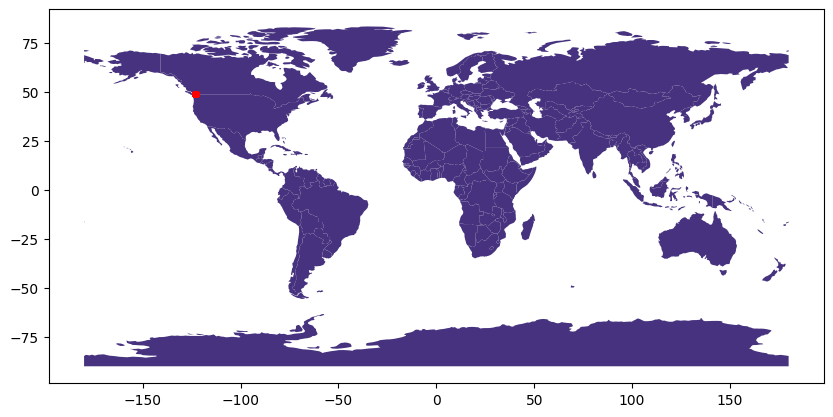

In [19]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Zooming in world plot to get detail of data

(49.180897, 49.333349)

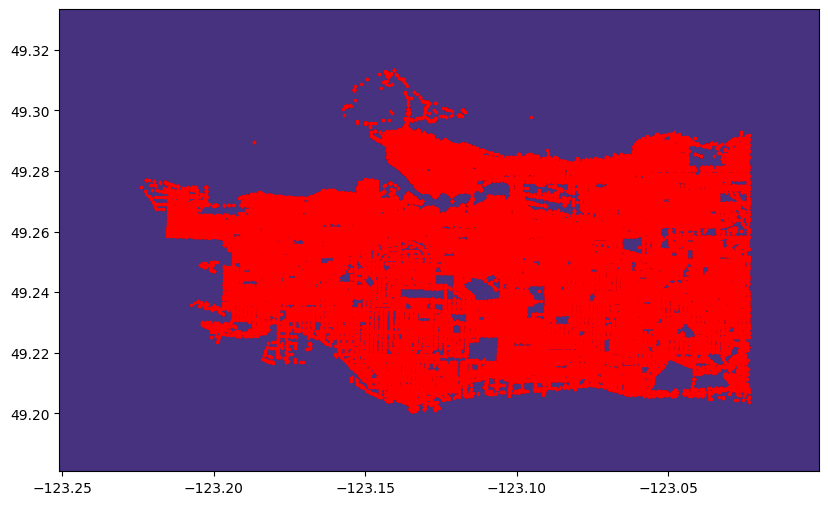

In [20]:
min_lon = -123.250955
max_lon = -123.000289
min_lat = 49.180897
max_lat = 49.333349

subset_gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6))
subset_gdf.plot(ax=ax, marker='o', color='red', markersize=2)

ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

plotting location with neighbourhood column.

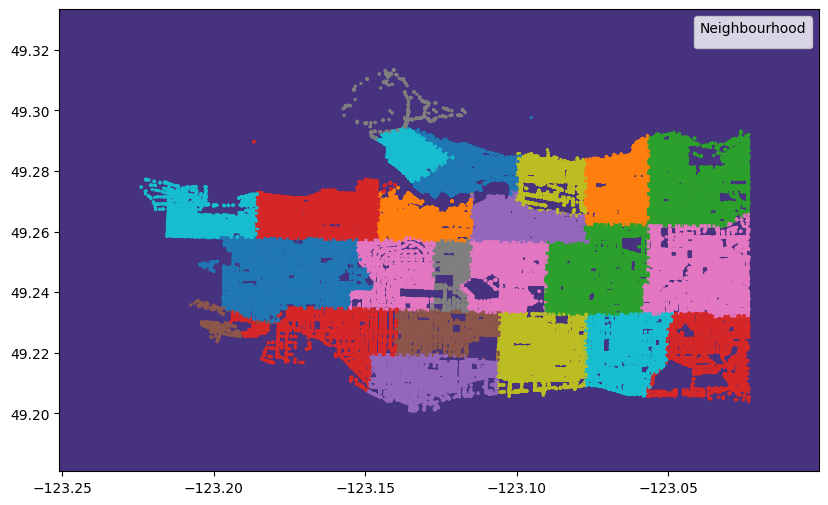

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(figsize=(10, 6))

subset_gdf.plot(ax=ax, column='NEIGHBOURHOOD', marker='o', markersize=2, legend=True)

min_lon, max_lon = -123.250955, -123.000289
min_lat, max_lat = 49.180897, 49.333349
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

ax.legend(title='Neighbourhood')

plt.show()

Checking increse and decreaase in crimes over time

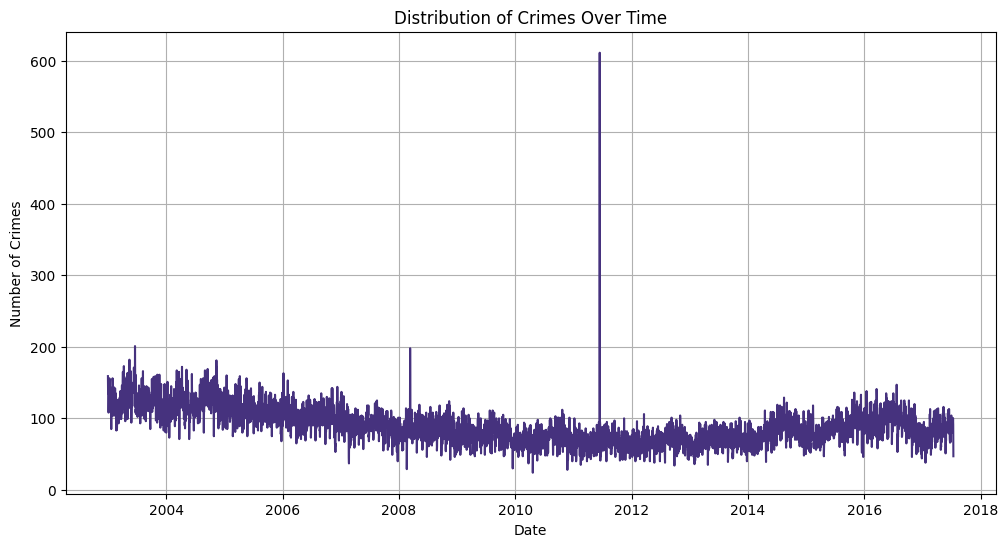

In [22]:
subset_gdf['Date'] = pd.to_datetime(subset_gdf[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE']])

crime_count_by_date = subset_gdf.groupby(subset_gdf['Date'].dt.date).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=crime_count_by_date, x='Date', y='Count')
plt.title('Distribution of Crimes Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.show()


Checking which crime occurs on which location most

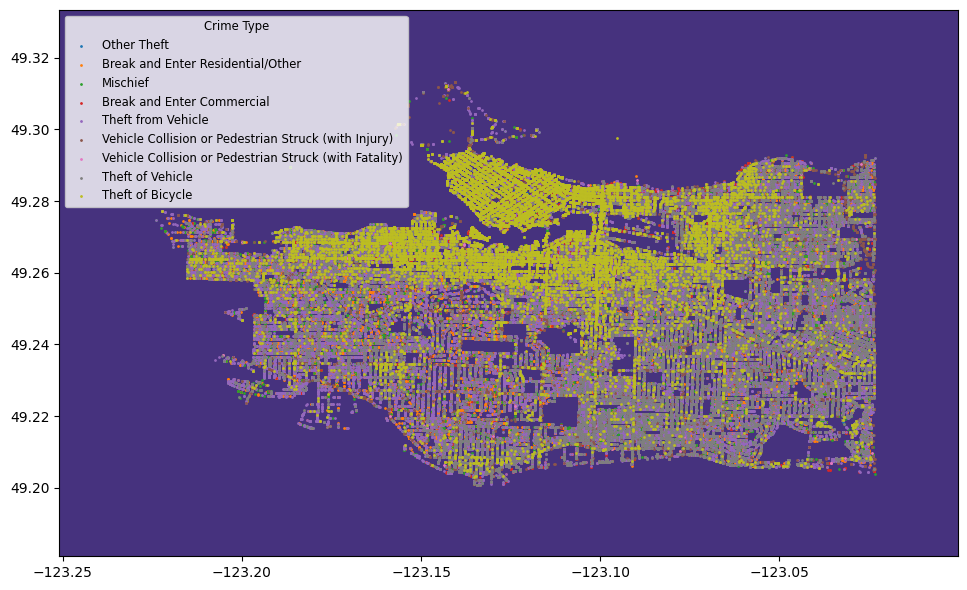

In [23]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6))

palette = sns.color_palette("tab10", n_colors=len(subset_gdf['TYPE'].unique()))


for i, crime_type in enumerate(subset_gdf['TYPE'].unique()):
    crime_subset = subset_gdf[subset_gdf['TYPE'] == crime_type]
    crime_subset.plot(ax=ax, marker='o', markersize=1, label=crime_type, color=palette[i])

min_lon, max_lon = -123.250955, -123.000289
min_lat, max_lat = 49.180897, 49.333349
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

ax.legend(title='Crime Type', loc='upper left', fontsize='small', title_fontsize='small')
plt.tight_layout()

# Show the plot
plt.show()


checking Count of Types of crime using count plot which shows Theft from vehicle occurs most

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Other Theft'),
  Text(1, 0, 'Break and Enter Residential/Other'),
  Text(2, 0, 'Mischief'),
  Text(3, 0, 'Break and Enter Commercial'),
  Text(4, 0, 'Theft from Vehicle'),
  Text(5, 0, 'Vehicle Collision or Pedestrian Struck (with Injury)'),
  Text(6, 0, 'Vehicle Collision or Pedestrian Struck (with Fatality)'),
  Text(7, 0, 'Theft of Vehicle'),
  Text(8, 0, 'Theft of Bicycle')])

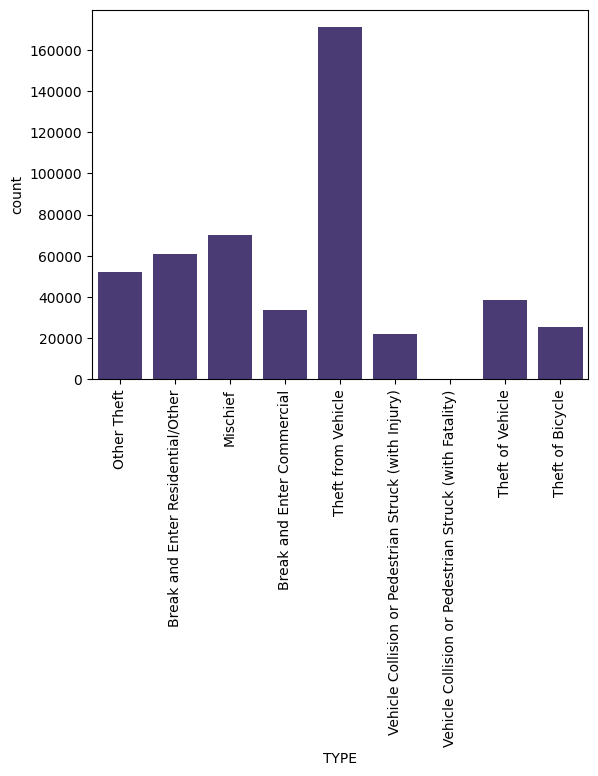

In [24]:
sns.countplot(x=df.TYPE)
plt.xticks(rotation=90)

checking most incident happens on which time.

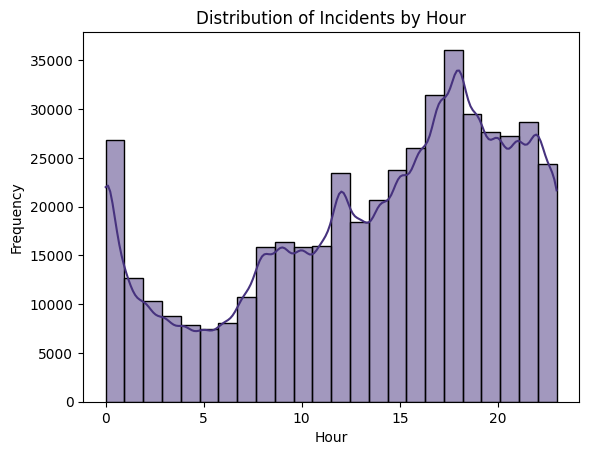

In [25]:
sns.histplot(df.HOUR, bins=24, kde=True)
plt.title('Distribution of Incidents by Hour')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

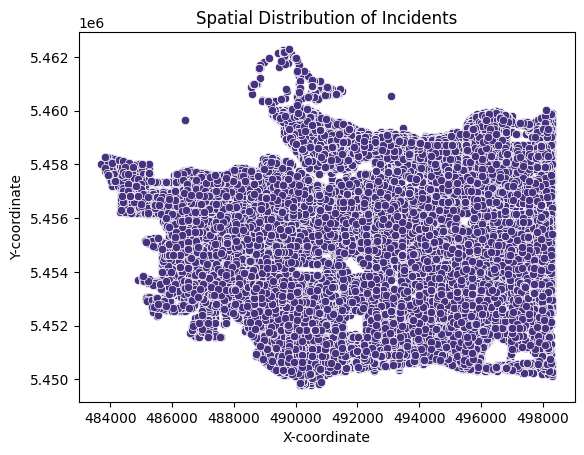

In [26]:
sns.scatterplot(data=df, x='X', y='Y')
plt.title('Spatial Distribution of Incidents')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.show()

checking type of crime in percetage form and pie diagram.

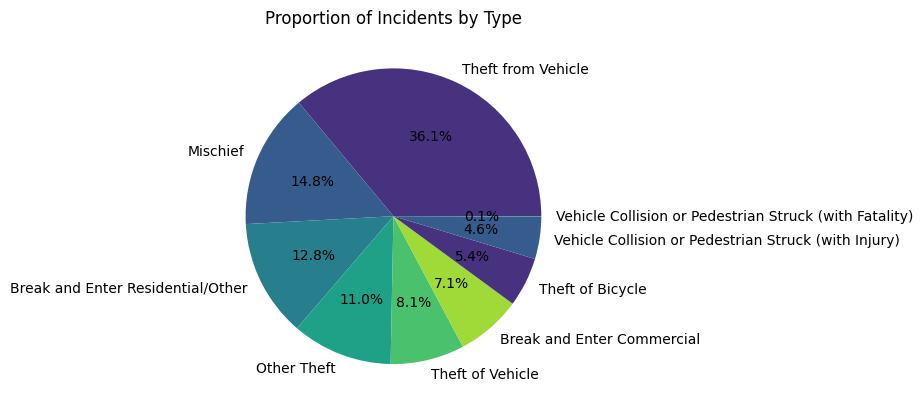

In [27]:
df['TYPE'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Proportion of Incidents by Type')
plt.ylabel('')
plt.show()

Checking IQR using boxplot for Types of crime.

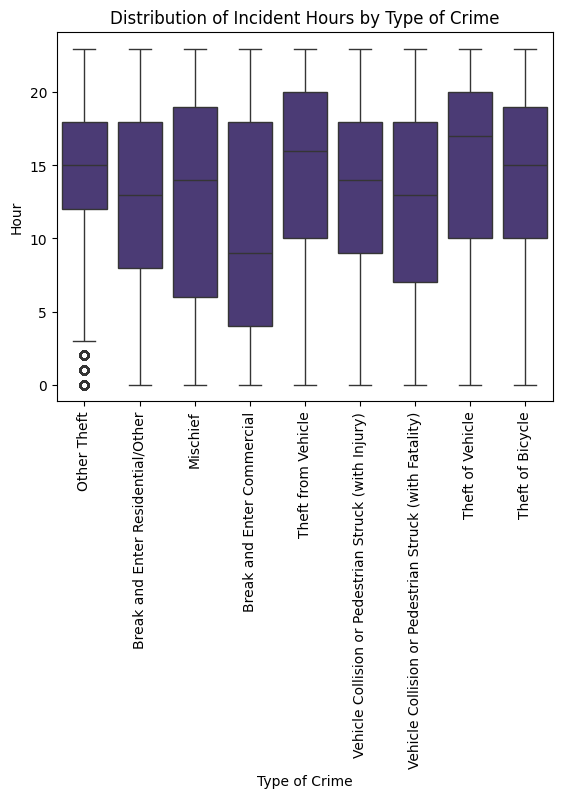

In [28]:
sns.boxplot(data=df, x='TYPE', y='HOUR')
plt.title('Distribution of Incident Hours by Type of Crime')
plt.xlabel('Type of Crime')
plt.ylabel('Hour')
plt.xticks(rotation=90)
plt.show()

checking on which time crime happends most using heatmap in which darker color shows most crimes and lighter color shows less crimes.

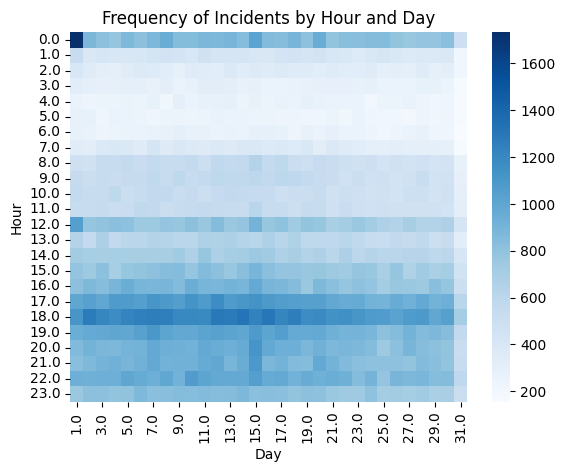

In [29]:
pivot = df.pivot_table(index='HOUR', columns='DAY', aggfunc='size')
sns.heatmap(pivot, cmap='Blues')
plt.title('Frequency of Incidents by Hour and Day')
plt.xlabel('Day')
plt.ylabel('Hour')
plt.show()

In [30]:
df

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude,Date
0,Other Theft,2003.0,5.0,12.0,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763,2003-05-12 16:15:00
1,Other Theft,2003.0,5.0,7.0,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763,2003-05-07 15:20:00
2,Other Theft,2003.0,4.0,23.0,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763,2003-04-23 16:40:00
3,Other Theft,2003.0,4.0,20.0,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763,2003-04-20 11:15:00
4,Other Theft,2003.0,4.0,12.0,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763,2003-04-12 17:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
530646,Mischief,2017.0,1.0,18.0,14.0,44.0,14XX E HASTINGS ST,Grandview-Woodland,494563.75,5458727.40,49.281276,-123.074746,2017-01-18 14:44:00
530647,Break and Enter Residential/Other,2017.0,3.0,3.0,9.0,16.0,31XX ADANAC ST,Hastings-Sunrise,497265.49,5458296.71,49.277420,-123.037595,2017-03-03 09:16:00
530648,Mischief,2017.0,5.0,29.0,22.0,30.0,14XX E 7TH AVE,Grandview-Woodland,494533.97,5456824.97,49.264163,-123.075129,2017-05-29 22:30:00
530650,Theft from Vehicle,2017.0,6.0,5.0,17.0,0.0,8XX HAMILTON ST,Central Business District,491487.85,5458385.78,49.278168,-123.117031,2017-06-05 17:00:00


Checking correlation between columns using heatmap

<Axes: >

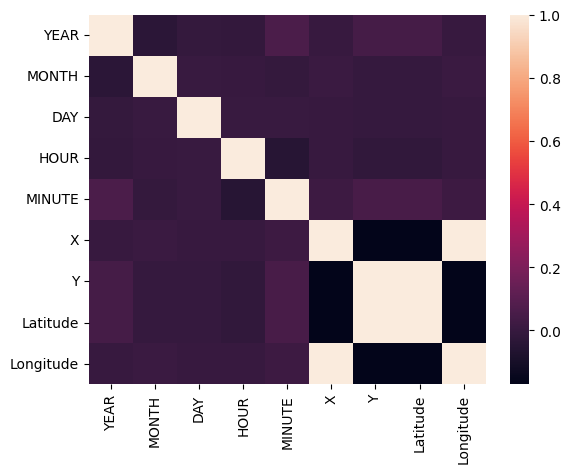

In [31]:
numerical_cols = df.select_dtypes(include=['int', 'float'])
sns.heatmap(numerical_cols.corr())

droping unneeded columns for training

In [32]:
df = df.drop(['YEAR', 'Date'], axis=1)

In [33]:
df

,TYPE,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,Other Theft,5.0,12.0,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
1,Other Theft,5.0,7.0,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
2,Other Theft,4.0,23.0,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
3,Other Theft,4.0,20.0,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
4,Other Theft,4.0,12.0,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
...,...,...,...,...,...,...,...,...,...,...,...
530646,Mischief,1.0,18.0,14.0,44.0,14XX E HASTINGS ST,Grandview-Woodland,494563.75,5458727.40,49.281276,-123.074746
530647,Break and Enter Residential/Other,3.0,3.0,9.0,16.0,31XX ADANAC ST,Hastings-Sunrise,497265.49,5458296.71,49.277420,-123.037595
530648,Mischief,5.0,29.0,22.0,30.0,14XX E 7TH AVE,Grandview-Woodland,494533.97,5456824.97,49.264163,-123.075129
530650,Theft from Vehicle,6.0,5.0,17.0,0.0,8XX HAMILTON ST,Central Business District,491487.85,5458385.78,49.278168,-123.117031


In [34]:
x = df.copy()

In [35]:
y = x.pop("TYPE")

To solve the issue of class inbalance. we are using RandomOverSampler to fix the issue

In [36]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(x, y)

balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=x.columns),
                         pd.DataFrame(y_resampled, columns=['TYPE'])],
                        axis=1)

# Check the class distribution after balancing
print(balanced_df['TYPE'].value_counts())

TYPE
Other Theft                                               170889
Break and Enter Residential/Other                         170889
Mischief                                                  170889
Break and Enter Commercial                                170889
Theft from Vehicle                                        170889
Vehicle Collision or Pedestrian Struck (with Injury)      170889
Vehicle Collision or Pedestrian Struck (with Fatality)    170889
Theft of Vehicle                                          170889
Theft of Bicycle                                          170889
Name: count, dtype: int64


In [37]:
# balanced_df = balanced_df[:100000]

In [38]:
x = balanced_df.copy()
y = x.pop("TYPE")

In [39]:
y

0                                                Other Theft
1                                                Other Theft
2                                                Other Theft
3                                                Other Theft
4                                                Other Theft
                                 ...                        
1537996    Vehicle Collision or Pedestrian Struck (with I...
1537997    Vehicle Collision or Pedestrian Struck (with I...
1537998    Vehicle Collision or Pedestrian Struck (with I...
1537999    Vehicle Collision or Pedestrian Struck (with I...
1538000    Vehicle Collision or Pedestrian Struck (with I...
Name: TYPE, Length: 1538001, dtype: object

In [40]:
x

,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,5.0,12.0,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
1,5.0,7.0,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
2,4.0,23.0,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
3,4.0,20.0,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
4,4.0,12.0,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
...,...,...,...,...,...,...,...,...,...,...
1537996,8.0,21.0,19.0,30.0,11XX BLOCK ROBSON ST,West End,490895.0,5459127.00,49.284827,-123.125198
1537997,7.0,15.0,15.0,48.0,15XX BLOCK E 49TH AVE,Victoria-Fraserview,494622.0,5452475.00,49.225035,-123.073861
1537998,6.0,26.0,9.0,32.0,BURRARD ST / PACIFIC ST,West End,490369.0,5458252.00,49.276948,-123.132410
1537999,11.0,24.0,18.0,15.0,FRASER ST / E 14TH AVE,Mount Pleasant,493508.0,5456134.00,49.257938,-123.089220


In [41]:
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [42]:
columns_to_encode = ["NEIGHBOURHOOD"]
columns_to_scale = ["X", "Y", "Latitude", "Longitude"]
columns_to_label_encode = ["HUNDRED_BLOCK"]

In [43]:
len(list(x.HUNDRED_BLOCK.value_counts()))

21192

Scaling Numerical columns between -1 and 1.

In [44]:
scaler = StandardScaler()

scaler.fit(x[columns_to_scale])

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [45]:
x[columns_to_scale]=scaler.transform(x[columns_to_scale])


In [46]:
x

,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,5.0,12.0,16.0,15.0,9XX TERMINAL AVE,Strathcona,0.578110,0.359321,0.360447,0.577776
1,5.0,7.0,15.0,20.0,9XX TERMINAL AVE,Strathcona,0.578110,0.359321,0.360447,0.577776
2,4.0,23.0,16.0,40.0,9XX TERMINAL AVE,Strathcona,0.578110,0.359321,0.360447,0.577776
3,4.0,20.0,11.0,15.0,9XX TERMINAL AVE,Strathcona,0.578110,0.359321,0.360447,0.577776
4,4.0,12.0,17.0,45.0,9XX TERMINAL AVE,Strathcona,0.578110,0.359321,0.360447,0.577776
...,...,...,...,...,...,...,...,...,...,...
1537996,8.0,21.0,19.0,30.0,11XX BLOCK ROBSON ST,West End,-0.508385,1.020306,1.019890,-0.509824
1537997,7.0,15.0,15.0,48.0,15XX BLOCK E 49TH AVE,Victoria-Fraserview,0.836249,-1.605429,-1.604320,0.837694
1537998,6.0,26.0,9.0,32.0,BURRARD ST / PACIFIC ST,West End,-0.698156,0.674918,0.674096,-0.699116
1537999,11.0,24.0,18.0,15.0,FRASER ST / E 14TH AVE,Mount Pleasant,0.434338,-0.161117,-0.160251,0.434553


Encoding categorical column using onehot encoding

In [47]:
encoder = OneHotEncoder(sparse=False)

encoded = encoder.fit_transform(x[["NEIGHBOURHOOD"]])

with open('onehotencoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

one_hot_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['NEIGHBOURHOOD']))
x = pd.concat([x, one_hot_df], axis=1)

x.drop('NEIGHBOURHOOD', axis=1, inplace=True)

x

,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,X,Y,Latitude,Longitude,NEIGHBOURHOOD_Arbutus Ridge,...,NEIGHBOURHOOD_Renfrew-Collingwood,NEIGHBOURHOOD_Riley Park,NEIGHBOURHOOD_Shaughnessy,NEIGHBOURHOOD_South Cambie,NEIGHBOURHOOD_Stanley Park,NEIGHBOURHOOD_Strathcona,NEIGHBOURHOOD_Sunset,NEIGHBOURHOOD_Victoria-Fraserview,NEIGHBOURHOOD_West End,NEIGHBOURHOOD_West Point Grey
0,5.0,12.0,16.0,15.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,5.0,7.0,15.0,20.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.0,23.0,16.0,40.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.0,20.0,11.0,15.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,12.0,17.0,45.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537996,8.0,21.0,19.0,30.0,11XX BLOCK ROBSON ST,-0.508385,1.020306,1.019890,-0.509824,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1537997,7.0,15.0,15.0,48.0,15XX BLOCK E 49TH AVE,0.836249,-1.605429,-1.604320,0.837694,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1537998,6.0,26.0,9.0,32.0,BURRARD ST / PACIFIC ST,-0.698156,0.674918,0.674096,-0.699116,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1537999,11.0,24.0,18.0,15.0,FRASER ST / E 14TH AVE,0.434338,-0.161117,-0.160251,0.434553,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
x

,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,X,Y,Latitude,Longitude,NEIGHBOURHOOD_Arbutus Ridge,...,NEIGHBOURHOOD_Renfrew-Collingwood,NEIGHBOURHOOD_Riley Park,NEIGHBOURHOOD_Shaughnessy,NEIGHBOURHOOD_South Cambie,NEIGHBOURHOOD_Stanley Park,NEIGHBOURHOOD_Strathcona,NEIGHBOURHOOD_Sunset,NEIGHBOURHOOD_Victoria-Fraserview,NEIGHBOURHOOD_West End,NEIGHBOURHOOD_West Point Grey
0,5.0,12.0,16.0,15.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,5.0,7.0,15.0,20.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.0,23.0,16.0,40.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.0,20.0,11.0,15.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,12.0,17.0,45.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537996,8.0,21.0,19.0,30.0,11XX BLOCK ROBSON ST,-0.508385,1.020306,1.019890,-0.509824,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1537997,7.0,15.0,15.0,48.0,15XX BLOCK E 49TH AVE,0.836249,-1.605429,-1.604320,0.837694,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1537998,6.0,26.0,9.0,32.0,BURRARD ST / PACIFIC ST,-0.698156,0.674918,0.674096,-0.699116,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1537999,11.0,24.0,18.0,15.0,FRASER ST / E 14TH AVE,0.434338,-0.161117,-0.160251,0.434553,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
x.columns

Index(['MONTH', 'DAY', 'HOUR', 'MINUTE', 'HUNDRED_BLOCK', 'X', 'Y', 'Latitude',
       'Longitude', 'NEIGHBOURHOOD_Arbutus Ridge',
       'NEIGHBOURHOOD_Central Business District',
       'NEIGHBOURHOOD_Dunbar-Southlands', 'NEIGHBOURHOOD_Fairview',
       'NEIGHBOURHOOD_Grandview-Woodland', 'NEIGHBOURHOOD_Hastings-Sunrise',
       'NEIGHBOURHOOD_Kensington-Cedar Cottage', 'NEIGHBOURHOOD_Kerrisdale',
       'NEIGHBOURHOOD_Killarney', 'NEIGHBOURHOOD_Kitsilano',
       'NEIGHBOURHOOD_Marpole', 'NEIGHBOURHOOD_Mount Pleasant',
       'NEIGHBOURHOOD_Musqueam', 'NEIGHBOURHOOD_Oakridge',
       'NEIGHBOURHOOD_Renfrew-Collingwood', 'NEIGHBOURHOOD_Riley Park',
       'NEIGHBOURHOOD_Shaughnessy', 'NEIGHBOURHOOD_South Cambie',
       'NEIGHBOURHOOD_Stanley Park', 'NEIGHBOURHOOD_Strathcona',
       'NEIGHBOURHOOD_Sunset', 'NEIGHBOURHOOD_Victoria-Fraserview',
       'NEIGHBOURHOOD_West End', 'NEIGHBOURHOOD_West Point Grey'],
      dtype='object')

doing label encoding to HUNDRED_BLOCK column to assign number to each category

In [50]:
label_encoder = LabelEncoder()

x['HUNDRED_BLOCK'] = label_encoder.fit_transform(x['HUNDRED_BLOCK'])

with open('labelencoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [51]:
x

,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,X,Y,Latitude,Longitude,NEIGHBOURHOOD_Arbutus Ridge,...,NEIGHBOURHOOD_Renfrew-Collingwood,NEIGHBOURHOOD_Riley Park,NEIGHBOURHOOD_Shaughnessy,NEIGHBOURHOOD_South Cambie,NEIGHBOURHOOD_Stanley Park,NEIGHBOURHOOD_Strathcona,NEIGHBOURHOOD_Sunset,NEIGHBOURHOOD_Victoria-Fraserview,NEIGHBOURHOOD_West End,NEIGHBOURHOOD_West Point Grey
0,5.0,12.0,16.0,15.0,14366,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,5.0,7.0,15.0,20.0,14366,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.0,23.0,16.0,40.0,14366,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.0,20.0,11.0,15.0,14366,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,12.0,17.0,45.0,14366,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537996,8.0,21.0,19.0,30.0,359,-0.508385,1.020306,1.019890,-0.509824,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1537997,7.0,15.0,15.0,48.0,1417,0.836249,-1.605429,-1.604320,0.837694,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1537998,6.0,26.0,9.0,32.0,15076,-0.698156,0.674918,0.674096,-0.699116,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1537999,11.0,24.0,18.0,15.0,17550,0.434338,-0.161117,-0.160251,0.434553,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
x["HUNDRED_BLOCK"] = x["HUNDRED_BLOCK"].astype(float)

Label Encoding target variable Y

In [53]:
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

with open('labelencoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [54]:
y

array([3, 3, 3, ..., 8, 8, 8])

Splitting data in to training and testing

In [55]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [56]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(1230400, 33)
(1230400,)
(307601, 33)
(307601,)


Training on Decision Tree Classifier

In [57]:
%%time
dt_model = DecisionTreeClassifier()
dt_model.fit(xtrain, ytrain)

# Make predictions
dt_ypred = dt_model.predict(xtest)

# Calculate evaluation metrics
dt_accuracy = accuracy_score(ytest, dt_ypred)
dt_precision = precision_score(ytest, dt_ypred, average='weighted')
dt_recall = recall_score(ytest, dt_ypred, average='weighted')
dt_f1 = f1_score(ytest, dt_ypred, average='weighted')

# Print evaluation metrics
print("Decision Tree - Accuracy:", dt_accuracy)
print("Decision Tree - Precision:", dt_precision)
print("Decision Tree - Recall:", dt_recall)
print("Decision Tree - F1 Score:", dt_f1)

Decision Tree - Accuracy: 0.9024613053923752
Decision Tree - Precision: 0.8992904413711891
Decision Tree - Recall: 0.9024613053923752
Decision Tree - F1 Score: 0.8938440939370578
CPU times: user 22 s, sys: 363 ms, total: 22.3 s
Wall time: 22.5 s


Training on Random Forest classifier

In [58]:
%%time
rf_model = RandomForestClassifier()
rf_model.fit(xtrain, ytrain)

# Make predictions
rf_ypred = rf_model.predict(xtest)

# Calculate evaluation metrics
rf_accuracy = accuracy_score(ytest, rf_ypred)
rf_precision = precision_score(ytest, rf_ypred, average='weighted')
rf_recall = recall_score(ytest, rf_ypred, average='weighted')
rf_f1 = f1_score(ytest, rf_ypred, average='weighted')

# Print evaluation metrics
print("Random Forest - Accuracy:", rf_accuracy)
print("Random Forest - Precision:", rf_precision)
print("Random Forest - Recall:", rf_recall)
print("Random Forest - F1 Score:", rf_f1)

Random Forest - Accuracy: 0.9183715267505632
Random Forest - Precision: 0.9161906845363396
Random Forest - Recall: 0.9183715267505632
Random Forest - F1 Score: 0.9133950951808993
CPU times: user 7min 52s, sys: 6.23 s, total: 7min 58s
Wall time: 8min


Training on Logistic Regression

In [59]:
%%time
lr_model = LogisticRegression()
lr_model.fit(xtrain, ytrain)

# Make predictions
lr_ypred = lr_model.predict(xtest)

# Calculate evaluation metrics
lr_accuracy = accuracy_score(ytest, lr_ypred)
lr_precision = precision_score(ytest, lr_ypred, average='weighted')
lr_recall = recall_score(ytest, lr_ypred, average='weighted')
lr_f1 = f1_score(ytest, lr_ypred, average='weighted')

# Print evaluation metrics
print("Logistic Regression - Accuracy:", lr_accuracy)
print("Logistic Regression - Precision:", lr_precision)
print("Logistic Regression - Recall:", lr_recall)
print("Logistic Regression - F1 Score:", lr_f1)

Logistic Regression - Accuracy: 0.2036989476627189
Logistic Regression - Precision: 0.1922940719516476
Logistic Regression - Recall: 0.2036989476627189
Logistic Regression - F1 Score: 0.16224335764549289
CPU times: user 1min 16s, sys: 30.1 s, total: 1min 46s
Wall time: 1min 9s


In [60]:
xtrain = xtrain[:100000]
ytrain = ytrain[:100000]
xtest = xtest[:20000]
ytest = ytest[:20000]

Training of K Nearest Neighbour

In [61]:
%%time
knn_model = KNeighborsClassifier()
knn_model.fit(xtrain, ytrain)

# Make predictions
knn_ypred = knn_model.predict(xtest)

# Calculate evaluation metrics
knn_accuracy = accuracy_score(ytest, knn_ypred)
knn_precision = precision_score(ytest, knn_ypred, average='weighted')
knn_recall = recall_score(ytest, knn_ypred, average='weighted')
knn_f1 = f1_score(ytest, knn_ypred, average='weighted')

# Print evaluation metrics
print("K Nearest Neighbors - Accuracy:", knn_accuracy)
print("K Nearest Neighbors - Precision:", knn_precision)
print("K Nearest Neighbors - Recall:", knn_recall)
print("K Nearest Neighbors - F1 Score:", knn_f1)

K Nearest Neighbors - Accuracy: 0.45625
K Nearest Neighbors - Precision: 0.44388980092686386
K Nearest Neighbors - Recall: 0.45625
K Nearest Neighbors - F1 Score: 0.4471354990372075
CPU times: user 23.1 s, sys: 80.2 ms, total: 23.1 s
Wall time: 14.3 s


In [80]:
x = x[:10000]
y = y[:10000]

In [81]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [82]:
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

In [83]:
ytrain

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

making architecture of Neural Network

In [84]:
model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(xtrain.shape[1],)))
# Hidden layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())  # Add batch normalization
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())  # Add batch normalization
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(9, activation='softmax'))

In [85]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


Training on Neural Network and storing results in history variable

In [86]:
history=model.fit(xtrain, ytrain, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/50
200/200 [==============================] - 3s 8ms/step - loss: 1.2730 - accuracy: 0.5219 - val_loss: 2.8033 - val_accuracy: 0.2350
Epoch 2/50
200/200 [==============================] - 1s 7ms/step - loss: 1.1389 - accuracy: 0.5484 - val_loss: 4.3597 - val_accuracy: 0.2181
Epoch 3/50
200/200 [==============================] - 1s 7ms/step - loss: 1.1099 - accuracy: 0.5630 - val_loss: 5.0558 - val_accuracy: 0.2412
Epoch 4/50
200/200 [==============================] - 1s 6ms/step - loss: 1.1268 - accuracy: 0.5555 - val_loss: 8.0118 - val_accuracy: 0.2950
Epoch 5/50
200/200 [==============================] - 1s 6ms/step - loss: 1.1177 - accuracy: 0.5586 - val_loss: 6.7084 - val_accuracy: 0.0581
Epoch 6/50
200/200 [==============================] - 1s 6ms/step - loss: 1.1264 - accuracy: 0.5578 - val_loss: 8.5769 - val_accuracy: 0.0487
Epoch 7/50
200/200 [==============================] - 1s 6ms/step - loss: 1.1368 - accuracy: 0.5559 - val_loss: 7.4800 - val_accuracy: 0.0969
Epoch 

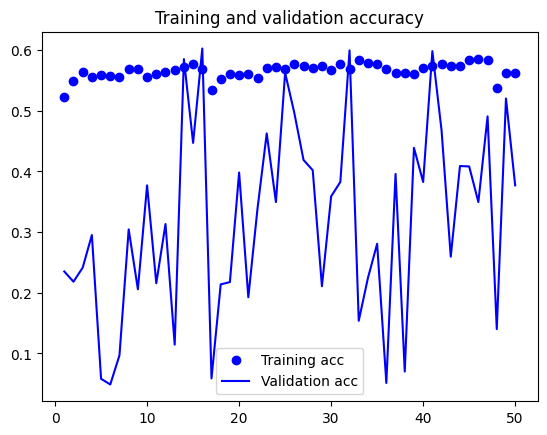

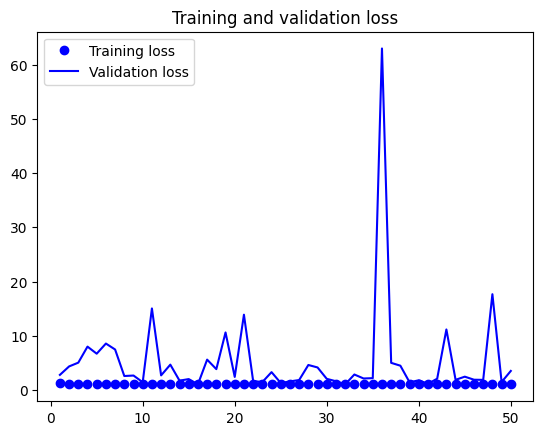

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Results

From all models ranking of best performing models are:
* **1 -----> Random Forest Classifier**
* 2 -----> Decision Tree Classifier
* 3 -----> K Nearest Neighbour
* 4 -----> Neural Networks